In [ ]:
#!git clone https://github.com/gjy3035/C-3-Framework.git
!git init
!git remote add mycountmycrowd https://github.com/xaviercallens/mycountmycrowdmob.git
!git push mycountmycrowdmob master

In [1]:
import azureml
from azureml.core import Workspace, Datastore, Experiment, Environment, Model
from azureml.core.resource_configuration import ResourceConfiguration
import urllib.request
from pathlib import Path
!pip install easydict
import easydict
from easydict import EasyDict

In [5]:
# This will open an device login prompt. Login with your credentials that have access to the workspace.
# Connect to the workspace
ws = Workspace.from_config()
print("Using workspace:",ws.name,"in region", ws.location)

# Connect to the default datastore
ds = ws.get_default_datastore()
print("Datastore:",ds.name)

Using workspace: xcatstmlc3 in region westeurope
Datastore: workspaceblobstore


In [10]:
# Create dataset directory
Path("dataset").mkdir(parents=True, exist_ok=True)

In [11]:
# Upload data to the data store
#XCA update dataset/SHHB
ds.upload('dataset', target_path='SHHB', overwrite=False, show_progress=True)
#ds.upload('dataset', target_path='cc_data/SHHB', overwrite=False, show_progress=True)

"Datastore.upload" is deprecated after version 1.0.69. Please use "Dataset.File.upload_directory" to upload your files             from a local directory and create FileDataset in single method call. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 3051 files
Target already exists. Skipping upload for SHHB/cc_data/.amlignore
Target already exists. Skipping upload for SHHB/cc_data/.amlignore.amltmp
Target already exists. Skipping upload for SHHB/cc_data/SHHB/.amlignore
Target already exists. Skipping upload for SHHB/cc_data/SHHB/.amlignore.amltmp
Target already exists. Skipping upload for SHHB/cc_data/SHHB/shanghaitech_part_B.zip
Target already exists. Skipping upload for SHHB/cc_data/SHHB/test_data/den/1.csv
Target already exists. Skipping upload for SHHB/cc_data/SHHB/test_data/den/10.csv
Target already exists. Skipping upload for SHHB/cc_data/SHHB/test_data/den/100.csv
Target already exists. Skipping upload for SHHB/cc_data/SHHB/test_data/den/101.csv
Target already exists. Skipping upload for SHHB/cc_data/SHHB/test_data/den/102.csv
Target already exists. Skipping upload for SHHB/cc_data/SHHB/test_data/den/103.csv
Target already exists. Skipping upload for SHHB/cc_data/SHHB/test_data/den/104.csv
Target a

$AZUREML_DATAREFERENCE_42ea63d5dd95489185be8b3b3b9f47da

In [6]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "xcallens3-4gpus"
# XCA min to 1 and low to high
try:
    cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Using compute cluster:', cluster_name)
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NV24', #Standard_NC24 before STANDARD_NC12 XCA update
                                                           vm_priority='highpriority',
                                                           min_nodes=1,
                                                           max_nodes=1)
    cluster = ComputeTarget.create(ws, cluster_name, compute_config)
    cluster.wait_for_completion(show_output=True)

Using compute cluster: xcallens3-4gpus


In [13]:
%%writefile C-3-Framework/trainRemoteCSRNet.py

import os
import argparse
import shutil
import numpy as np
import torch
import easydict
#XCA update

from torch import optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from models.CC import CrowdCounter
from misc.utils import *
from config import cfg
from easydict import EasyDict
#XCA update

from trainer import Trainer
# Prepare Trainer for AzureML by overide utils logger with Azure logger TDB
def logger(exp_path, exp_name, work_dir, exception, resume=False):
    from tensorboardX import SummaryWriter
    if not os.path.exists(exp_path):
        os.mkdir(exp_path)
    writer = SummaryWriter(exp_path+ '/' + exp_name)
    log_file = exp_path + '/' + exp_name + '/' + exp_name + '.txt'
    print('log file:', log_file) #XCA update
    return writer, log_file

class AzureMLTrainer(Trainer):

    def __init__(self, dataloader, cfg_data, pwd):
        self.cfg_data = cfg_data

        self.data_mode = cfg.DATASET
        self.exp_name = cfg.EXP_NAME
        self.exp_path = cfg.EXP_PATH
        self.pwd = pwd

        self.net_name = cfg.NET
        self.net = CrowdCounter(cfg.GPU_ID,self.net_name).cuda()
        self.optimizer = optim.Adam(self.net.CCN.parameters(), lr=cfg.LR, weight_decay=1e-4)
        # self.optimizer = optim.SGD(self.net.parameters(), cfg.LR, momentum=0.95,weight_decay=5e-4)
        self.scheduler = StepLR(self.optimizer, step_size=cfg.NUM_EPOCH_LR_DECAY, gamma=cfg.LR_DECAY)          

        self.train_record = {'best_mae': 1e20, 'best_mse':1e20, 'best_model_name': ''}
        self.timer = {'iter time' : Timer(),'train time' : Timer(),'val time' : Timer()} 

        self.epoch = 0
        self.i_tb = 0
        
        if cfg.PRE_GCC:
            self.net.load_state_dict(torch.load(cfg.PRE_GCC_MODEL))

        self.train_loader, self.val_loader, self.restore_transform = dataloader()

        self.writer, self.log_txt = logger(self.exp_path, self.exp_name, self.pwd, 'exp', resume=cfg.RESUME)
        
#------------Process Inputs------------
parser = argparse.ArgumentParser(description='MCNN Trainer')
parser.add_argument('--data_folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--max_epoch', type=int, default=600, help='number of epochs to train') #XCA change to 10 from 100

args = parser.parse_args()

cfg.DATASET = 'SHHB'
cfg.NET = 'CSRNet'
#cfg.NET = 'AlexNet'

cfg.MAX_EPOCH = args.max_epoch

#------------Prepare Data------------
#SHHB_PATH = os.path.join(args.data_folder, 'cc_data/{}'.format(cfg.DATASET))
#XCA update
SHHB_PATH = './dataset/SHHB/' # working remote but laterom error

print('path:', SHHB_PATH) #XCA update

if not os.path.isdir(os.path.join(SHHB_PATH,'train')):
    from zipfile import ZipFile
    # Create a ZipFile Object and load sample.zip in it
    with ZipFile(os.path.join(SHHB_PATH,'shanghaitech_part_B.zip'), 'r') as zipObj:
        zipObj.extractall(SHHB_PATH)
        os.rename(os.path.join(SHHB_PATH,'train_data'), os.path.join(SHHB_PATH,'train'))
        os.rename(os.path.join(SHHB_PATH,'test_data'), os.path.join(SHHB_PATH,'test'))
os.path.abspath('')
os.path.split(os.path.realpath(os.path.abspath('')))

#------------Start Training------------
from datasets.SHHB.loading_data import loading_data 
from datasets.SHHB.setting import cfg_data 
cfg_data.DATA_PATH = SHHB_PATH
pwd = os.path.split(os.path.realpath(os.path.abspath('')))[0]
cc_trainer = AzureMLTrainer(loading_data,cfg_data,pwd)
cc_trainer.forward()

#------------Copy Model Output------------        
CSRNet_model = shutil.copytree(os.path.join(cfg.EXP_PATH, cfg.EXP_NAME), './outputs/exp')

Writing C-3-Framework/trainRemoteCSRNet.py


In [7]:
# Create an experiment or connect if it exists
from azureml.train.estimator import Estimator
experiment_name = "crowdcounting_SHHB_CSRNet_4GPUs_realtest_600epochs_xca" #UCF50_AlexNet_4000epoch.pth
exp = Experiment(workspace=ws, name=experiment_name)

In [8]:
script_params = {
    '--data_folder': ds,
}

cc_est = Estimator(source_directory='./C-3-Framework',
                   script_params=script_params,
                   compute_target=cluster,
                   use_gpu=True,
                   entry_script='trainRemoteCSRNet.py',
                   pip_packages=['torch',
                                 'torchvision',
                                 'tensorboardX',
                                 'tensorboard',
                                 'tensorflow',
                                 'easydict',
                                 'pandas',
                                 'numpy',
                                 'scipy'])

'Estimator' is deprecated. Please use 'ScriptRunConfig' from 'azureml.core.script_run_config' with your own defined environment or an Azure ML curated environment.


In [16]:
run = exp.submit(cc_est)

Submitting /mnt/batch/tasks/shared/LS_root/mounts/clusters/xcallens2-4gpus/code/Users/xcallens/C-3-Framework directory for run. The size of the directory >= 25 MB, so it can take a few minutes.


In [9]:
# Select a previous run
run = [r for r in exp.get_runs() if r.id == 'crowdcounting_SHHB_CSRNet_4GPUs_realtest_600epochs_xca_1646297815_5a845ee7'][0] #XCA to be updated to the last value of the Run Id from the experiment console
#cc_MCNN_1645707248_946378a5 from XCA run old cc_MCNN_1583914876_137247d1   new cc_MCNN_xca_1645734773_6abcba4a

In [10]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [11]:
model = run.register_model(model_name = 'CSRNET-CrowdCounting-Model', 
                     model_path = 'outputs/exp/all_ep_529_mae_9.1_mse_14.1.pth',  # CSRNet large improvement from all_ep_595_mae_36.6_mse_57.1.pth with MCNN test with Users/xcallens/pretrainedmodel/UCF50_AlexNet_4000epoch.pth before ok outputs/exp/all_ep_97_mae_42.0_mse_65.0.pth all_ep_11_mae_58.2_mse_79.5 try outputs/exp/all_ep_11_mae_58.2_mse_79.5.pth all_ep_97_mae_42.0_mse_65.0.pth  
#
#/mnt/batch/tasks/shared/LS_root/mounts/clusters/xcallens2-4gpus/code/Users/xcallens/C-3-Framework
#all_ep_595_mae_36.6_mse_57.1.pth
                     model_framework =  Model.Framework.CUSTOM,
                     description = 'CSRNet Crowd Counting Model',
                     tags={'area': 'CV', 'type': 'CSRNet', 'model_author': "C-3-Framework"},
                     resource_configuration = ResourceConfiguration(cpu=1, gpu=2, memory_in_gb=2))

print('version:', model.version)

version: 3


In [12]:
Path("./temp").mkdir(parents=True, exist_ok=True)
model.download(exist_ok=True,target_dir="./temp")

'temp/all_ep_529_mae_9.1_mse_14.1.pth'

In [13]:
#import easydict
#from easydict import EasyDict

from matplotlib import pyplot as plt
import matplotlib
import random
import torch
import sys


sys.path.insert(0, './C-3-Framework')
from torch.autograd import Variable
import torchvision.transforms as standard_transforms
import misc.transforms as own_transforms
import pandas as pd

from models.CC import CrowdCounter
from config import cfg
cfg.NET = "CSRNet" #XCA change
from misc.utils import *
import scipy.io as sio
from PIL import Image, ImageOps


torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True

In [14]:
cfg.NET

'CSRNet'

In [16]:
mean_std = ([0.452016860247, 0.447249650955, 0.431981861591],[0.23242045939, 0.224925786257, 0.221840232611])
img_transform = standard_transforms.Compose([
        standard_transforms.ToTensor(),
        standard_transforms.Normalize(*mean_std)
    ])
restore = standard_transforms.Compose([
        own_transforms.DeNormalize(*mean_std),
        standard_transforms.ToPILImage()
    ])
pil_to_tensor = standard_transforms.ToTensor()


model_path = './temp/all_ep_595_mae_36.6_mse_57.1.pth'


In [17]:
myGPU_ID = [0,1]
net = CrowdCounter(myGPU_ID,'MCNN')
print('Nb of GPUS',myGPU_ID) #XCA update ! GPU for inference
net.load_state_dict(torch.load(model_path))
net.cuda()
net.eval()

Nb of GPUS [0, 1]


CrowdCounter(
  (CCN): DataParallel(
    (module): MCNN(
      (branch1): Sequential(
        (0): Conv2d(
          (conv): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
          (relu): ReLU(inplace=True)
        )
        (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (2): Conv2d(
          (conv): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
          (relu): ReLU(inplace=True)
        )
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(
          (conv): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
          (relu): ReLU(inplace=True)
        )
        (5): Conv2d(
          (conv): Conv2d(16, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
          (relu): ReLU(inplace=True)
        )
      )
      (branch2): Sequential(
        (0): Conv2d(
          (conv): Conv2d(3, 20, kernel_size=(7, 7), stride=(1, 1), padding

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


110.0 people


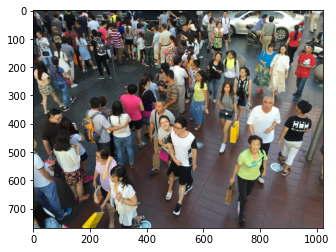

In [18]:
img_path1 = './airporttest/existingSHHB101.jpg'

img = Image.open(img_path1)
plt.imshow(img)

if img.mode == 'L':
    img = img.convert('RGB')
img = img_transform(img)
with torch.no_grad():
    img = Variable(img[None,:,:,:]).cuda()
    pred_map = net.test_forward(img)

pred_map = pred_map.cpu().data.numpy()[0,0,:,:]
pred = np.sum(pred_map)/100.0
pred_map = pred_map/np.max(pred_map+1e-20)
print("{} people".format(pred.round()))

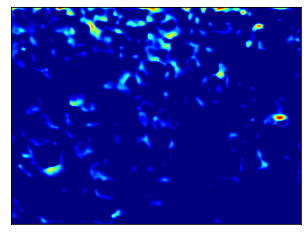

In [19]:
pred_frame = plt.gca()
plt.imshow(pred_map, 'jet')
pred_frame.axes.get_yaxis().set_visible(False)
pred_frame.axes.get_xaxis().set_visible(False)

71.0 people


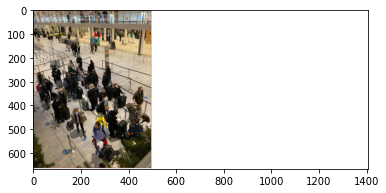

In [20]:
img_path2 = './airporttest/airportfromproject.jpg'


img2 = Image.open(img_path2)
plt.imshow(img2)

if img2.mode == 'L':
    img2 = img.convert('RGB')
img2 = img_transform(img2)
with torch.no_grad():
    img2 = Variable(img2[None,:,:,:]).cuda()
    pred_map = net.test_forward(img2)

pred_map = pred_map.cpu().data.numpy()[0,0,:,:]
pred = np.sum(pred_map)/100.0
pred_map = pred_map/np.max(pred_map+1e-20)
print("{} people".format(pred.round()))

210.0 people


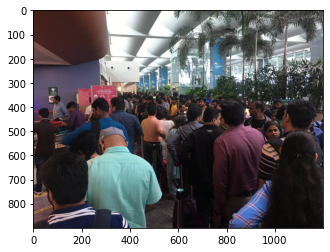

In [34]:
img_path3 = './airporttest/airportcongestion1.jpg'


img3 = Image.open(img_path3)
plt.imshow(img3)

if img3.mode == 'L':
    img3 = img.convert('RGB')
img3 = img_transform(img3)
with torch.no_grad():
    img3 = Variable(img3[None,:,:,:]).cuda()
    pred_map = net.test_forward(img3)

pred_map = pred_map.cpu().data.numpy()[0,0,:,:]
pred = np.sum(pred_map)/100.0
pred_map = pred_map/np.max(pred_map+1e-20)
print("{} people".format(pred.round()))

32.0 people


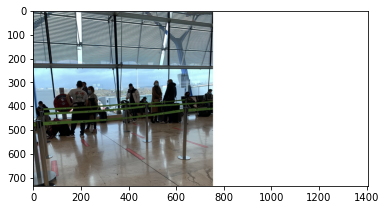

In [22]:
img_path4 = './airporttest/testPAIResized.jpg' #Users/xcallens/airporttest/testPAIResized.jpg


img4 = Image.open(img_path4)
plt.imshow(img4)

if img4.mode == 'L':
    img4 = img.convert('RGB')
img4 = img_transform(img4)
with torch.no_grad():
    img4 = Variable(img4[None,:,:,:]).cuda()
    pred_map = net.test_forward(img4)

pred_map = pred_map.cpu().data.numpy()[0,0,:,:]
pred = np.sum(pred_map)/100.0
pred_map = pred_map/np.max(pred_map+1e-20)
print("{} people".format(pred.round()))

In [29]:
img_path5 = './airporttest/testPAI2resized.jpg' #Users/xcallens/airporttest/testPAIResized.jpg Users/xcallens/airporttest/testPAI2resized.jpg


img4 = Image.open(img_path5)
plt.imshow(img5)

if img4.mode == 'L':
    img4 = img.convert('RGB')
img4 = img_transform(img5)
with torch.no_grad():
    img4 = Variable(img5[None,:,:,:]).cuda()
    pred_map = net.test_forward(img4)

pred_map = pred_map.cpu().data.numpy()[0,0,:,:]
pred = np.sum(pred_map)/100.0
pred_map = pred_map/np.max(pred_map+1e-20)
print("{} people".format(pred.round()))

NameError: name 'img5' is not defined